<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/8.recurrent_neural_networks/8_6_concise_implementation_of_recurrent_neural_networks_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import tensorflow as tf
import random
import tensorflow as tf
import collections
import re
import hashlib
import os
import tarfile
import zipfile
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
import time

In [48]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [49]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [50]:
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

In [51]:
def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [52]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

In [53]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [54]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [55]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield tf.constant(X), tf.constant(Y)

In [56]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = tf.constant(corpus[offset: offset + num_tokens])
    Ys = tf.constant(corpus[offset + 1: offset + 1 + num_tokens])
    Xs = tf.reshape(Xs, (batch_size, -1))
    Ys = tf.reshape(Ys, (batch_size, -1))
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [57]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [58]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [59]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [60]:
num_hiddens = 256
rnn_cell = tf.keras.layers.SimpleRNNCell(num_hiddens,
    kernel_initializer='glorot_uniform')

rnn_layer = tf.keras.layers.RNN(rnn_cell, time_major=True,
    return_sequences=True, return_state=True)

state = rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
state.shape

TensorShape([32, 256])

In [61]:
X = tf.random.uniform((num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(TensorShape([35, 32, 256]), TensorShape([32, 256]))

In [62]:
class RNNModel(tf.keras.layers.Layer):

  def __init__(self, rnn_layer, vocab_size, **kwargs):
    super(RNNModel, self).__init__(**kwargs)
    self.rnn = rnn_layer
    self.vocab_size = vocab_size
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, state):

    X = tf.one_hot(tf.transpose(inputs), self.vocab_size)
    Y, *state = self.rnn(X, state)
    output = self.dense(tf.reshape(Y, (-1, Y.shape[-1])))
    return output, state
  
  def begin_state(self, *args, **kwargs):
    return self.rnn.cell.get_initial_state(*args, **kwargs)

In [63]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))
    devices = [tf.device(f'/GPU:{i}') for i in range(num_gpus)]
    return devices if devices else [tf.device('/CPU:0')]

In [64]:
def predict_ch8(prefix, num_preds, net, vocab):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, dtype=tf.float32)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: tf.reshape(tf.constant([outputs[-1]]), (1, 1)).numpy()
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.numpy().argmax(axis=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [65]:
device_name = try_gpu()._device_name
strategy = tf.distribute.OneDeviceStrategy(device_name)
with strategy.scope():
    net = RNNModel(rnn_layer, vocab_size=len(vocab))

predict_ch8('time traveller', 10, net, vocab)

'time travellersbdqlujvtb'

In [66]:
def grad_clipping(grads, theta):
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad

In [67]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [68]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [69]:
def train_epoch_ch8(net, train_iter, loss, updater, use_random_iter):
    """Train a model within one epoch (defined in Chapter 8)."""
    state, timer = None, Timer()
    metric = Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], dtype=tf.float32)
        with tf.GradientTape(persistent=True) as g:
            
            y_hat, state = net(X, state)
            
            y = tf.reshape(tf.transpose(Y), (-1))
            l = loss(y, y_hat)
        
        params = net.trainable_variables
        grads = g.gradient(l, params)
        
        grads = grad_clipping(grads, 1)
        
        updater.apply_gradients(zip(grads, params))

        # Keras loss by default returns the average loss in a batch
        # l_sum = l * float(d2l.size(y)) if isinstance(
        #     loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l * tf.size(y).numpy(), tf.size(y).numpy())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [70]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, strategy,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        updater = tf.keras.optimizers.SGD(lr)

    ui_x = []
    ui_y = []
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            ui_x.append(epoch + 1)
            ui_y.append(ppl)
    device = try_gpu()._device_name
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

    plt.plot(ui_x, ui_y, 'r')
    plt.show()

time traveller ou the thing sore the thas an the the the thand t
time traveller thit that in the the thes in there the thice is a
time travellerthet and her thes in and thas iout tareed the fire
time traveller the cad of the s ime same the t an thave is that 
time traveller the e dimentions and there whack ofoche travely g
time traveller thy e mone th tree th th thee thin ther thie sthe
time traveller the rid is theno s ang the gimine sove plonght en
time travelleryou dan thon ther aid cante in thane three dimensi
time traveller this that raver a der the thaved this that nis in
time traveller tro eemed iny of he work ald thitk sist rof armat
time traveller but red y inc end and this sain thi g ancalnis of
time traveller hred in sprepent ang the mithe rave thetoneanoste
time traveller s me thit soo thit tomere dion the time time timb
time travellerit s against reason sy got an there and rof co din
time traveller held in his hand was a glitt filbyct ferithe s th
time travellerractly hal 

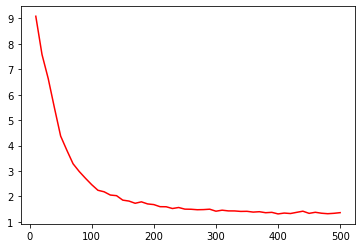

In [71]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, strategy)